In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
#import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import random
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from numpy import absolute
import tensorflow as tf
import os
from PIL import Image

In [2]:
# Klasör yolları ve etiketler
klasorler_ve_etiketler = [
    {'path': r"C:\Users\Van_P\OneDrive\Masaüstü\Projects\Deep Learning\İmage_process\Dinosaur_Project\Dinosaurs", 'label': 1},  # Dinozorlar için yol ve etiket
    {'path': r"C:\Users\Van_P\OneDrive\Masaüstü\Projects\Deep Learning\İmage_process\Dinosaur_Project\Mammals", 'label': 0}     # Memeliler için yol ve etiket
]

data = []
labels = []

# Her klasör için resimleri yükle ve etiketle
for item in klasorler_ve_etiketler:
    folder_path = item['path']  # Klasör yolu
    label = item['label']  # Etiket
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg'):  # jpg formatındaki dosyaları kontrol et
            img_path = os.path.join(folder_path, filename)
            image = Image.open(img_path).convert('RGB')  # Resmi RGB olarak dönüştür
            image = image.resize((128, 128))  # Görüntü boyutunu yeniden boyutlandır
            data.append(np.array(image))
            labels.append(label)  # Etiketi sayısal olarak atama

# Veri ve etiketleri numpy dizilerine dönüştür
data = np.array(data)
labels = np.array(labels)

# Etiketlerdeki benzersiz değerler ve her birinden kaçar tane olduğunu bulma
unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Sınıf Dağılımı:", class_distribution)

# Hata ayıklama: Dizilerin boyutlarını kontrol et
print(f"data shape: {data.shape}")
print(f"labels shape: {labels.shape}")

Sınıf Dağılımı: {0: 162, 1: 129}
data shape: (291, 128, 128, 3)
labels shape: (291,)


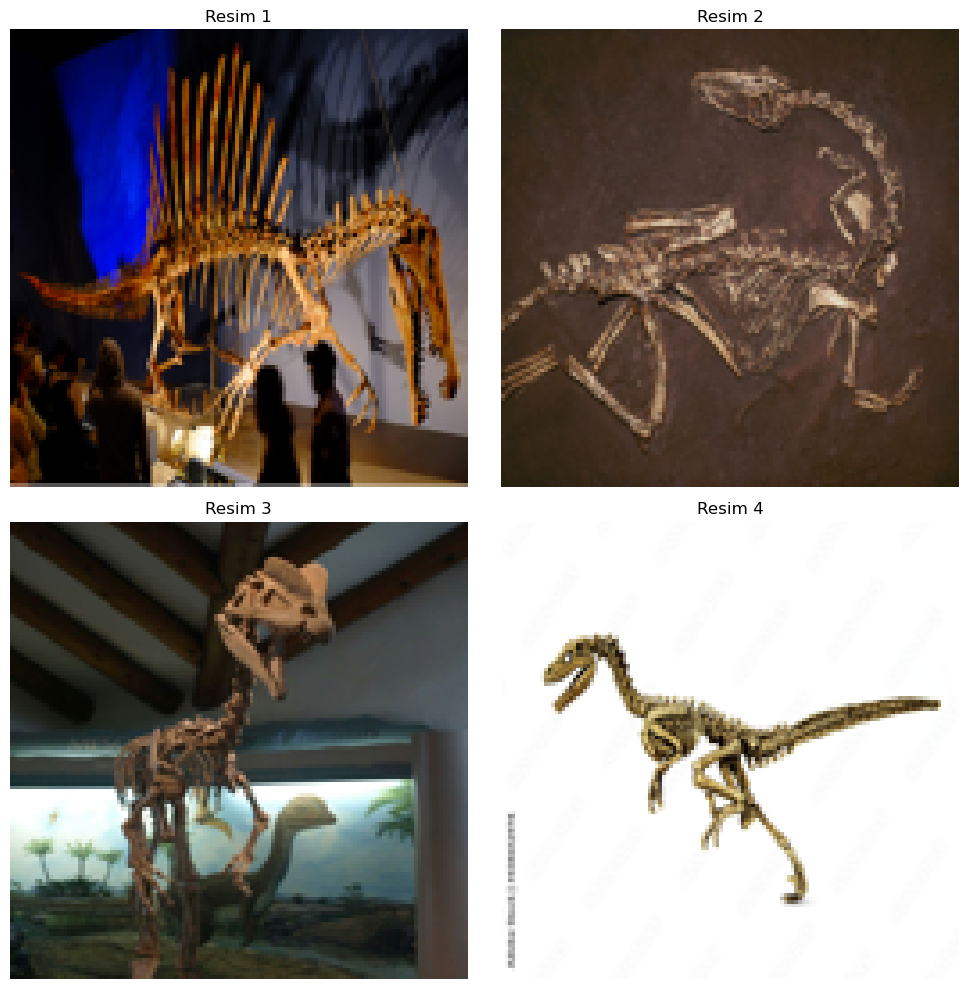

In [3]:
# İlk 4 resmi bir grid içinde göster
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2x2 bir subplot grid'i oluştur
axs = axs.ravel()  # Subplot'ları tek bir dizi olarak düzleştir

for i in range(4):  # İlk 4 resmi döngü içinde göster
    axs[i].imshow(data[i])
    axs[i].set_title(f"Resim {i+1}")
    axs[i].axis('off')  # Eksenleri kapat

plt.tight_layout()  # Düzeni iyileştir
plt.show()

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,  # 40 dereceye kadar rastgele döndürme
    width_shift_range=0.2,  # Görüntü genişliğinin %20'sine kadar yatay kaydırma
    height_shift_range=0.2,  # Görüntü yüksekliğinin %20'sine kadar dikey kaydırma
    shear_range=0.2,  # 0.2 kesme yoğunluğunda görüntüleri kaydırma
    zoom_range=[0.8,1.2],  # %80 ila %120 arasında rastgele yakınlaştırma/uzaklaştırma
    horizontal_flip=True,  # Yatay çevirme
    vertical_flip=True,  # Yeni eklenen dikey çevirme
    brightness_range=[0.5, 1.5],  # Parlaklığı %50 azaltıp %50 artırma
    fill_mode='reflect',  # 'nearest', 'constant', 'reflect', 'wrap' seçeneklerinden 'reflect' kullanımı
)

In [180]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize
# Veri setini %60 eğitim, %40 test olarak bölme
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.4, shuffle=True, random_state=42)

# Geçici test setini (%40) %20 doğrulama ve %20 test olarak bölme
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

# Görüntüleri yeniden boyutlandırma fonksiyonu
def resize_images(images, new_size=(512, 512)):
    resized_images = np.array([resize(image, new_size, anti_aliasing=True) for image in images])
    return resized_images

# Görüntüleri yeniden boyutlandır ve 0-1 aralığına ölçeklendir
X_train_resized = resize_images(X_train) * 255
X_val_resized = resize_images(X_val) * 255
X_test_resized = resize_images(X_test) * 255

# Veri artırma için ImageDataGenerator nesnesini eğitim seti için oluşturma
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Görüntüleri 0-1 aralığına ölçeklendirme
    rotation_range=40,  # 40 dereceye kadar rastgele döndürme
    width_shift_range=0.2,  # Görüntü genişliğinin %20'sine kadar yatay kaydırma
    height_shift_range=0.2,  # Görüntü yüksekliğinin %20'sine kadar dikey kaydırma
    shear_range=0.2,  # 0.2 kesme yoğunluğunda görüntüleri kaydırma
    zoom_range=[0.8, 1.2],  # %80 ila %120 arasında rastgele yakınlaştırma/uzaklaştırma
    horizontal_flip=True,  # Yatay çevirme
    vertical_flip=True,  # Dikey çevirme
    brightness_range=[0.5, 1.5],  # Parlaklığı %50 azaltıp %50 artırma
    fill_mode='reflect'  # 'reflect' doldurma modu
)

# Doğrulama ve test setleri için veri artırma uygulanmayacak
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Generator'ları oluşturma
train_generator = train_datagen.flow(X_train_resized, y_train, batch_size=8)
val_generator = test_val_datagen.flow(X_val_resized, y_val, batch_size=8)
test_generator = test_val_datagen.flow(X_test_resized, y_test, batch_size=8)


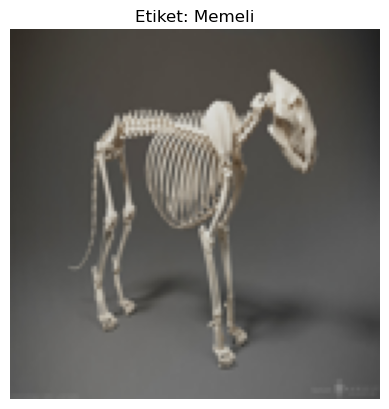

In [98]:
#Setler arası Label Kontrol
def show_image_with_label(index, X_train, y_train):
    """Belirtilen indeksteki resmi ve etiketini gösterir."""
    plt.imshow(X_train[index])
    plt.title(f"Etiket: {'Dinozor' if y_train[index] == 1 else 'Memeli'}")
    plt.axis('off')  # Eksenleri kapat
    plt.show()

# Örnek olarak, 0. indeksteki resmi ve etiketini göster
show_image_with_label(88, X_train, y_train)

In [99]:
# y_train içindeki benzersiz etiketler ve her birinden kaç tane olduğunu bulma
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Sınıf Dağılımı:", class_distribution)

Sınıf Dağılımı: {0: 102, 1: 72}


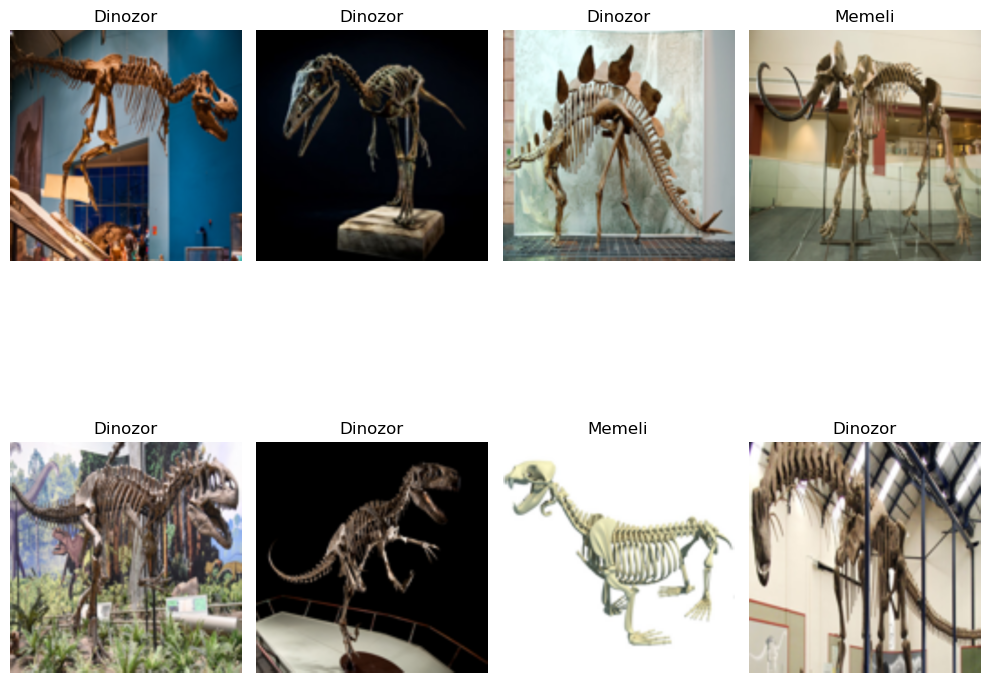

In [188]:
import matplotlib.pyplot as plt

def show_images_from_generator(generator, class_labels, num_images=8):
    # Generator'dan bir batch al
    images, labels = next(generator)
    
    # Görselleri ve etiketleri çiz
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(2, num_images//2, i + 1)
        plt.imshow(images[i])
        # Eğer etiketler one-hot encoding ile kodlanmışsa aşağıdaki satırı kullanın
        # plt.title(class_labels[np.argmax(labels[i])])
        # Eğer etiketler zaten sayısal (0, 1 gibi) ise aşağıdaki satırı kullanın
        plt.title(class_labels[int(labels[i])])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Eğitim generator'undan görselleri ve etiketleri göster
class_labels = ['Memeli', 'Dinozor']
show_images_from_generator(val_generator, class_labels)


### MODEL

In [169]:
MAX_SIDE_LEN = 512  # Giriş görüntü boyutu

model = models.Sequential()

# İlk Conv2D katmanı
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN, 3), kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0.00001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.15))

# İkinci Conv2D katmanı
model.add(layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.00001, l2=0.00001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  

# Üçünü Conv2D katmanı
model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.000001, l2=0.00001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.15))  

# Dördüncü Conv2D katmanı
model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.000001, l2=0.00001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.15))  

# Beşinci Conv2D katmanı
model.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.000001, l2=0.00001)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.15))  

model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())

# İlk tam bağlı dense katmanı
model.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.000001, l2=0.00001)))
model.add(layers.Dropout(0.15))  

# İkinci tam bağlı dense katmanı
model.add(layers.Dense(128, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.000001, l2=0.00001)))
model.add(layers.Dropout(0.25))

# Üçüncü tam bağlı dense katmanı
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.000001, l2=0.00001)))
model.add(layers.Dropout(0.15))

# Dördüncü tam bağlı dense katmanı
model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.000001, l2=0.00001)))
model.add(layers.Dropout(0.15))

# Beşinci tam bağlı dense katmanı
model.add(layers.Dense(32, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=0.000001, l2=0.00001)))
model.add(layers.Dropout(0.15))

# Çıktı katmanı
model.add(layers.Dense(1, activation='sigmoid')) 

# Model özeti
model.summary()

# EarlyStopping callback'ini ayarlayın
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,  
    restore_best_weights=True 
)


# Modeli derleme
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])


Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_162 (Conv2D)         (None, 510, 510, 128)     3584      
                                                                 
 max_pooling2d_159 (MaxPool  (None, 255, 255, 128)     0         
 ing2D)                                                          
                                                                 
 dropout_297 (Dropout)       (None, 255, 255, 128)     0         
                                                                 
 conv2d_163 (Conv2D)         (None, 253, 253, 128)     147584    
                                                                 
 max_pooling2d_160 (MaxPool  (None, 126, 126, 128)     0         
 ing2D)                                                          
                                                                 
 dropout_298 (Dropout)       (None, 126, 126, 128)   

In [170]:
# Model eğitimi
history = model.fit(
    train_generator,  # Eğitim seti için veri artırma ile oluşturulan generator
    epochs=100,  # Kaç epoch eğitileceği
    validation_data=val_generator,  # Doğrulama seti için generator
    callbacks=[early_stopping],  # Erken durma nesnesini callback olarak ekle
    verbose=2  # Eğitim sırasında bilgi gösterim düzeyi
)

Epoch 1/100
22/22 - 62s - loss: 0.7611 - accuracy: 0.4943 - val_loss: 0.7566 - val_accuracy: 0.5862 - 62s/epoch - 3s/step
Epoch 2/100
22/22 - 62s - loss: 0.7554 - accuracy: 0.4828 - val_loss: 0.7524 - val_accuracy: 0.5862 - 62s/epoch - 3s/step
Epoch 3/100
22/22 - 57s - loss: 0.7547 - accuracy: 0.5460 - val_loss: 0.7499 - val_accuracy: 0.5862 - 57s/epoch - 3s/step
Epoch 4/100
22/22 - 58s - loss: 0.7632 - accuracy: 0.5287 - val_loss: 0.7445 - val_accuracy: 0.5862 - 58s/epoch - 3s/step
Epoch 5/100
22/22 - 57s - loss: 0.7457 - accuracy: 0.5747 - val_loss: 0.7488 - val_accuracy: 0.5862 - 57s/epoch - 3s/step
Epoch 6/100
22/22 - 58s - loss: 0.7490 - accuracy: 0.5632 - val_loss: 0.7469 - val_accuracy: 0.5862 - 58s/epoch - 3s/step
Epoch 7/100
22/22 - 57s - loss: 0.7455 - accuracy: 0.5920 - val_loss: 0.7439 - val_accuracy: 0.5862 - 57s/epoch - 3s/step
Epoch 8/100
22/22 - 57s - loss: 0.7490 - accuracy: 0.5632 - val_loss: 0.7437 - val_accuracy: 0.5862 - 57s/epoch - 3s/step
Epoch 9/100
22/22 - 57s 

KeyboardInterrupt: 

In [179]:
# Model değerlendirme
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print(f"Test seti üzerindeki kayıp: {test_loss}, Doğruluk: {test_acc}")

8/8 - 3s - loss: 0.7516 - accuracy: 0.4407 - 3s/epoch - 383ms/step
Test seti üzerindeki kayıp: 0.7515657544136047, Doğruluk: 0.4406779706478119


In [122]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Resmi yükleme ve boyutunu değiştirme
img_path = r'C:\Users\Van_P\OneDrive\Masaüstü\Projects\Deep Learning\İmage_process\Dinosaur_Project/deneme10.jpg'
img = image.load_img(img_path, target_size=(128, 128))

# Resmi array'e dönüştürme ve ölçeklendirme
img_array = image.img_to_array(img) / 255.0

# Modelin beklediği şekle getirme (1, 128, 128, 3)
img_array = np.expand_dims(img_array, axis=0)

# Tahmin yapma
predictions = model.predict(img_array)

# Tahmini yazdırma
class_names = ['Memeli', 'Dinozor']  # Sınıf isimlerini projenize göre ayarlayın
threshold = 0.5
predicted_class = class_names[int(predictions > threshold)]

print(f"Model, bu resmi bir {predicted_class} olarak tahmin ediyor.")

1/1 [==============================] - 0s 115ms/step
Model, bu resmi bir Memeli olarak tahmin ediyor.


In [88]:
predictions

array([[0.41684338]], dtype=float32)